# Neural networks based approximation of an analytical function

In this notebook, we will show how to train a neural network to approximate an analytical function. 
The same procedure can be used to approximate any unknown function, for example using real world data.

For convenience, the neural network implementation of this package handles the conversion between NumPy arrays and PyTorch tensors, so we won't directly manipulate any PyTorch `Tensor` in this notebook.

The analytical function and the network will be saved in the `out-training` directory. 

In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(""), ".."))

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

import torch
from torch import nn, optim

from nnbma.networks import FullyConnected
from nnbma.dataset import RegressionDataset
from nnbma.learning import learning_procedure, LearningParameters

from functions import Fexample as F

## Definition of the analytical function

In the following cell, we load and instantiate a vectorial function $f$ implemented as a PyTorch `Module`. For more details on the implementation, see `functions.py`. You can implement your own by following the model.

The function is the following:

In [2]:
md(F.latex())

$$\left(\begin{array}{c} t_1\\ t_2 \end{array}\right) \longmapsto \left(\begin{array}{c} t_1+2t_2\\ t_1^2\\ t_1t_2^2 \end{array}\right)$$

In [3]:
f = F()

ranges = [
    (-2.0, 2.0),
    (-1.0, 1.0),
]  # Range of values of all inputs of f. Can be modified but must be consistent with the imported function.

n_points = 100  # Number of points needed to plot a profile

default_values = [
    0.0,
    0.0,
]  # Default values of all inputs of f when plotting a profile. Can be modified but must be consistent with the imported function.

At this point, consider that `f` is just a function that maps vectors into other vectors (but we will see in other notebooks that it is actually more than that, for example it can be derived automatically or integrated into a neural network if desired).

For instance, we can plot some profiles of `f`:

In [4]:
# Index of free input, the others being restricted to their default value.
input_to_plot = 1  # Must be between 1 and f.n_inputs

x = np.array(default_values) * np.ones((n_points, f.n_inputs), dtype="float")
x[:, input_to_plot - 1] = np.linspace(*ranges[input_to_plot - 1], n_points)
print("x.shape:", x.shape)

y = f(x)
print("y.shape:", y.shape)

x.shape: (100, 2)
y.shape: (100, 3)


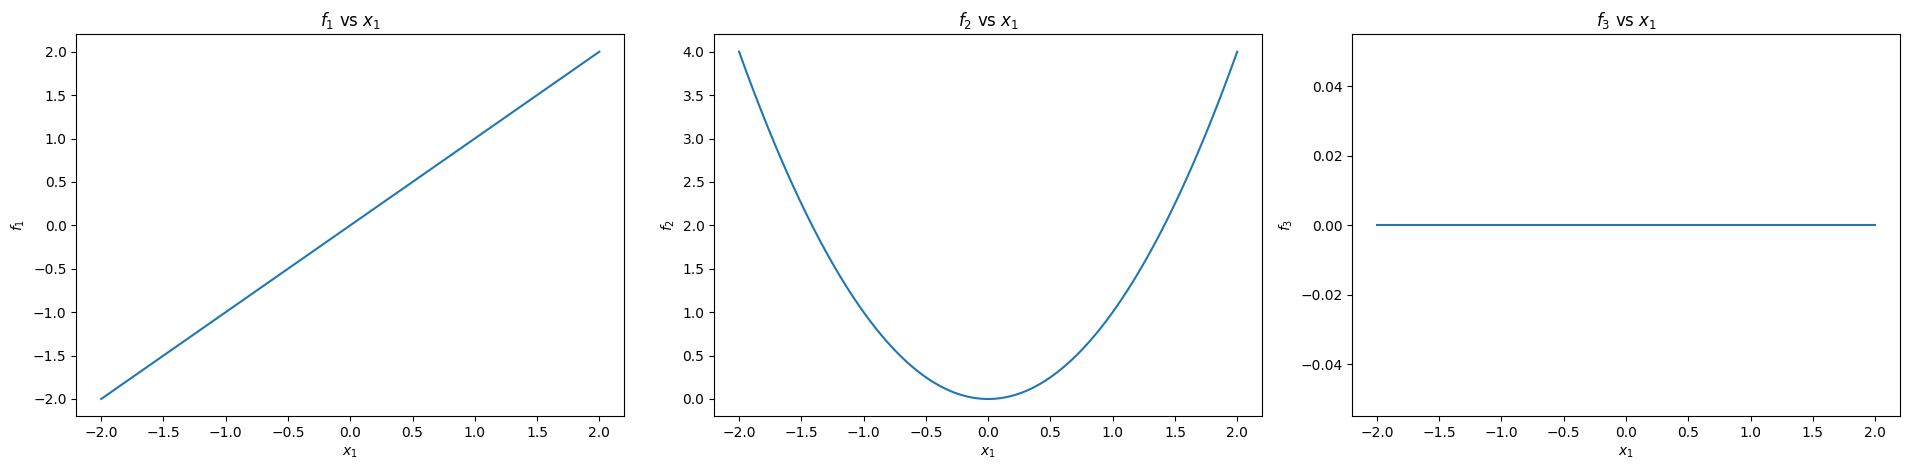

In [5]:
plt.figure(figsize=(f.n_outputs * 6.4, 4.8))

for j in range(f.n_outputs):

    plt.subplot(1, f.n_outputs, j + 1)

    plt.plot(x[:, input_to_plot - 1], y[:, j])

    plt.xlabel(f"$x_{input_to_plot}$")
    plt.ylabel(f"$f_{j+1}$")
    plt.title(f"$f_{j+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()

plt.show()

We can also draw a bivariate plot:

In [6]:
# Index of free inputs, the others being restricted to their default value.
inputs_to_plot = (1, 2)  # Must be between 1 and f.n_inputs

X = np.dstack(
    np.meshgrid(
        *[
            np.linspace(*ranges[i], n_points)
            if i + 1 in inputs_to_plot
            else default_values[i] * np.ones(n_points)
            for i in range(f.n_inputs)
        ]
    )
)
print("X.shape:", X.shape)

Y = f(X)
print("Y.shape:", Y.shape)

X.shape: (100, 100, 2)
Y.shape: (100, 100, 3)


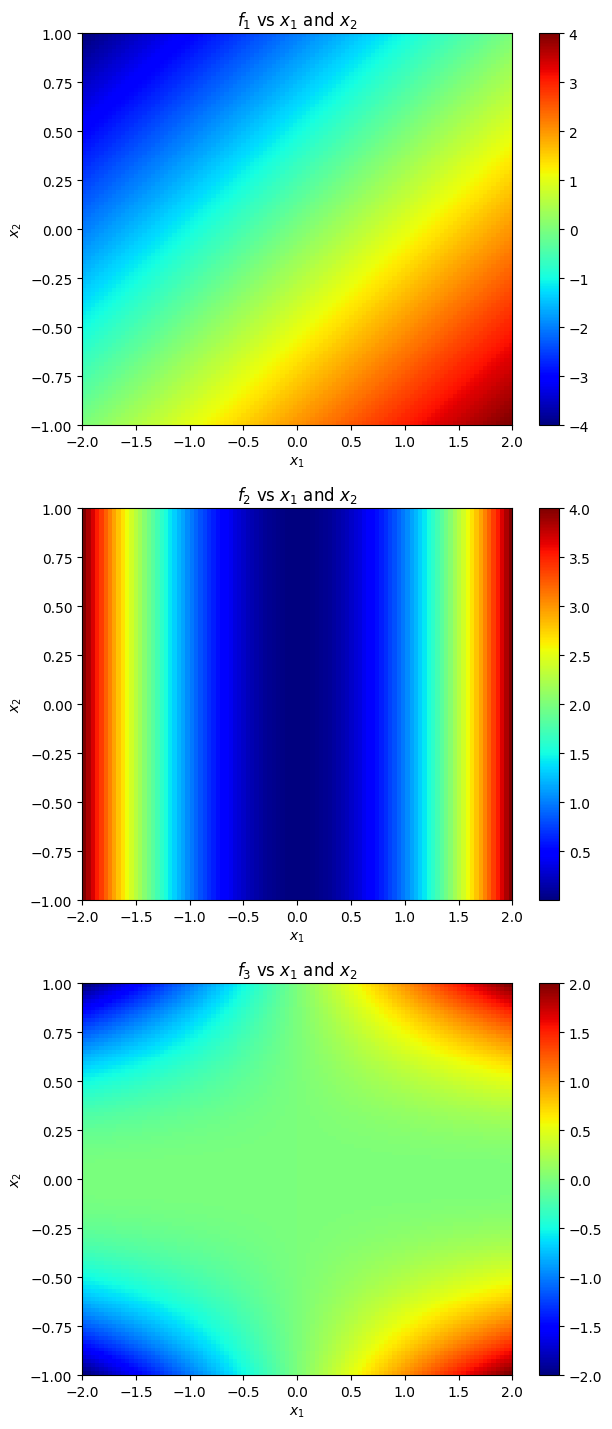

In [7]:
plt.figure(figsize=(6.4, 4.8 * f.n_outputs))

for j in range(f.n_outputs):
    plt.subplot(f.n_outputs, 1, j + 1)
    plt.imshow(
        Y[..., j],
        cmap="jet",
        aspect="auto",
        extent=[
            ranges[inputs_to_plot[0] - 1][0],
            ranges[inputs_to_plot[0] - 1][1],
            ranges[inputs_to_plot[1] - 1][0],
            ranges[inputs_to_plot[1] - 1][1],
        ],
    )
    plt.colorbar()

    plt.xlabel(f"$x_{inputs_to_plot[0]}$")
    plt.ylabel(f"$x_{inputs_to_plot[1]}$")
    plt.title(f"$f_{j+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$")

plt.tight_layout()

plt.show()

## Creation of a neural network

We will create a fully connected neural network. To do so, we have to define, some hyperparameters:
* the number of hidden layers
* their respective number of neurons

In [8]:
layers_sizes = [f.n_inputs, 100, 100, f.n_outputs]
activation = nn.GELU()

net_0 = FullyConnected(
    layers_sizes,
    activation,
)

net = net_0.copy()

The weights are initialized randomly so, before any training, we obtain plots like that:

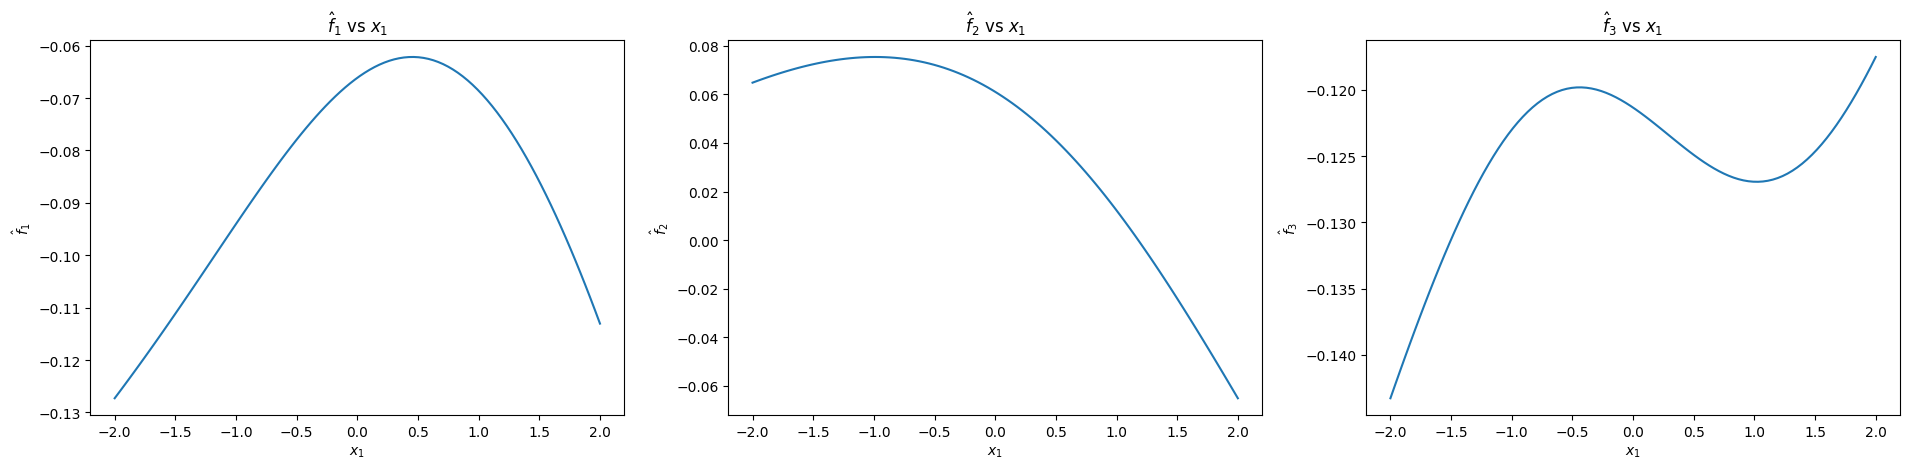

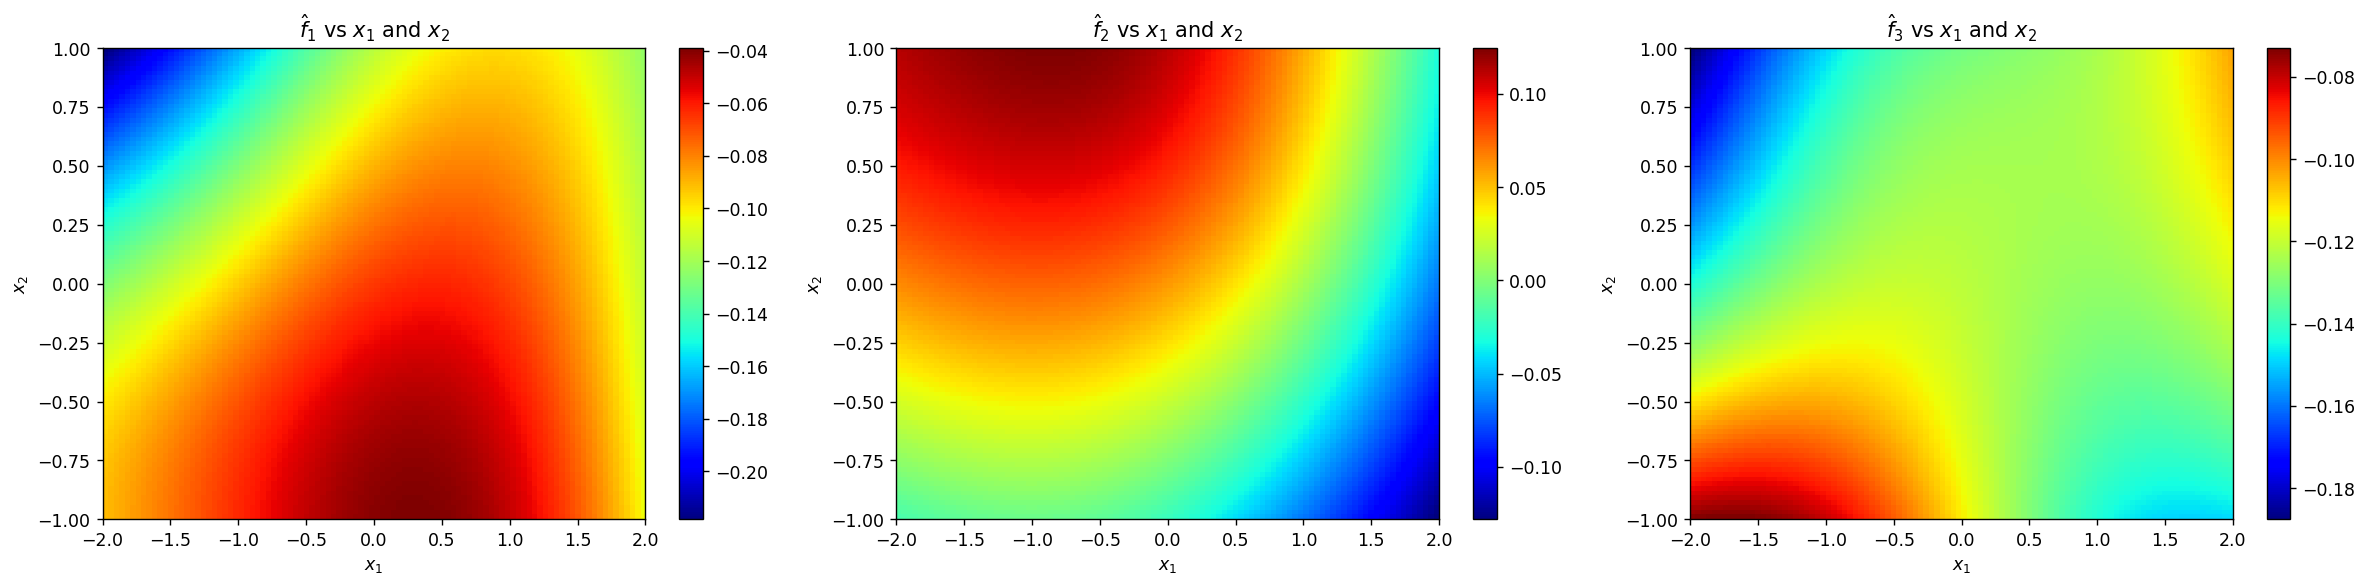

In [9]:
y_net_0 = net_0(torch.from_numpy(x).float())

plt.figure(figsize=(6.4 * f.n_outputs, 4.8))

for j in range(f.n_outputs):
    plt.subplot(1, f.n_outputs, j + 1)
    plt.plot(x[:, input_to_plot - 1], y_net_0[:, j])

    plt.xlabel(f"$x_{input_to_plot}$")
    plt.ylabel(f"$\\hat{{f}}_{j+1}$")
    plt.title(f"$\\hat{{f}}_{j+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()
plt.show()

#
Y_net_0 = net_0(torch.from_numpy(X).float())

plt.figure(dpi=125, figsize=(6.4 * f.n_outputs, 4.8))

for j in range(f.n_outputs):
    plt.subplot(1, f.n_outputs, j + 1)
    plt.imshow(
        Y_net_0[..., j],
        cmap="jet",
        aspect="auto",
        extent=[
            ranges[inputs_to_plot[0] - 1][0],
            ranges[inputs_to_plot[0] - 1][1],
            ranges[inputs_to_plot[1] - 1][0],
            ranges[inputs_to_plot[1] - 1][1],
        ],
    )
    plt.colorbar()

    plt.xlabel(f"$x_{inputs_to_plot[0]}$")
    plt.ylabel(f"$x_{inputs_to_plot[1]}$")
    plt.title(
        f"$\\hat{{f}}_{j+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$"
    )

plt.tight_layout()
plt.show()

## Training of the network

We will train this network in order to approximate the previous function. To do so, we generate a dataset of randomly distributed points (not a grid like the one used to draw the figures).

The following cell controls the size of the whole dataset, and which fraction of it will be used to test the model instead of improve its learning.

In [10]:
n_data = 20_000
test_frac = 0.20

In [11]:
input_data = np.column_stack(
    [np.random.uniform(*ranges[k], n_data) for k in range(f.n_inputs)]
)
output_data = f(input_data)

dataset = RegressionDataset(input_data, output_data)

We also need some parameters to control the learning procedure:
* the number of epochs
* the batch size
* the loss function
* the learning rate
* the optimizer
* the learning rate scheduler

In [12]:
# Epochs
epochs = 100

# Batch size
batch_size = 100

# Loss function
loss = nn.MSELoss()

# Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(net.parameters(), learning_rate)

# Scheduler
gamma = (1e-2) ** (1 / epochs)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

The next cell will launch the training procedure. It will modify the weights of the network in-place.

In [13]:
learning_params = LearningParameters(loss, epochs, batch_size, optimizer, scheduler)

results = learning_procedure(
    net,
    dataset,
    learning_params,
    val_frac=test_frac,
)

print("Results keys:", list(results.keys()))

Training initiated
FullyConnected:
	layers_sizes: [2, 100, 100, 3]
	activation: GELU(approximate='none')
	batch_norm: False
	inputs_names: None
	outputs_names: None
	inputs_transformer: None
	outputs_transformer: None
	device: cpu
	last_restrictable: True
: 10,703 learnable parameters (42.81 kB)



Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, train loss=6.72e-6, val loss=6.88e-6, train error=0.39%, val error=0.39%] 


Results keys: ['train_loss', 'val_loss', 'train_relerr', 'val_relerr', 'train_set', 'val_set', 'lr', 'batch_size', 'duration']


We can plot the evolution of both train and test loss:

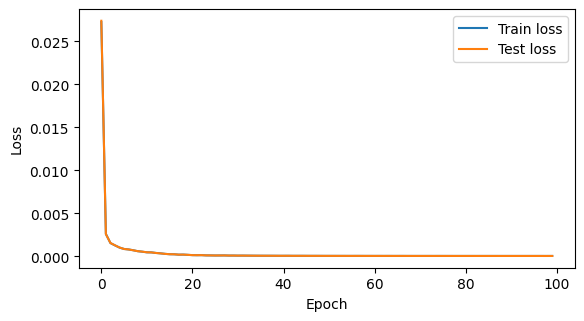

In [14]:
plt.figure(figsize=(6.4, 0.7 * 4.8))

plt.plot(results["train_loss"], label="Train loss")
plt.plot(results["val_loss"], label="Test loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

We now diplay the new plots with the trained network

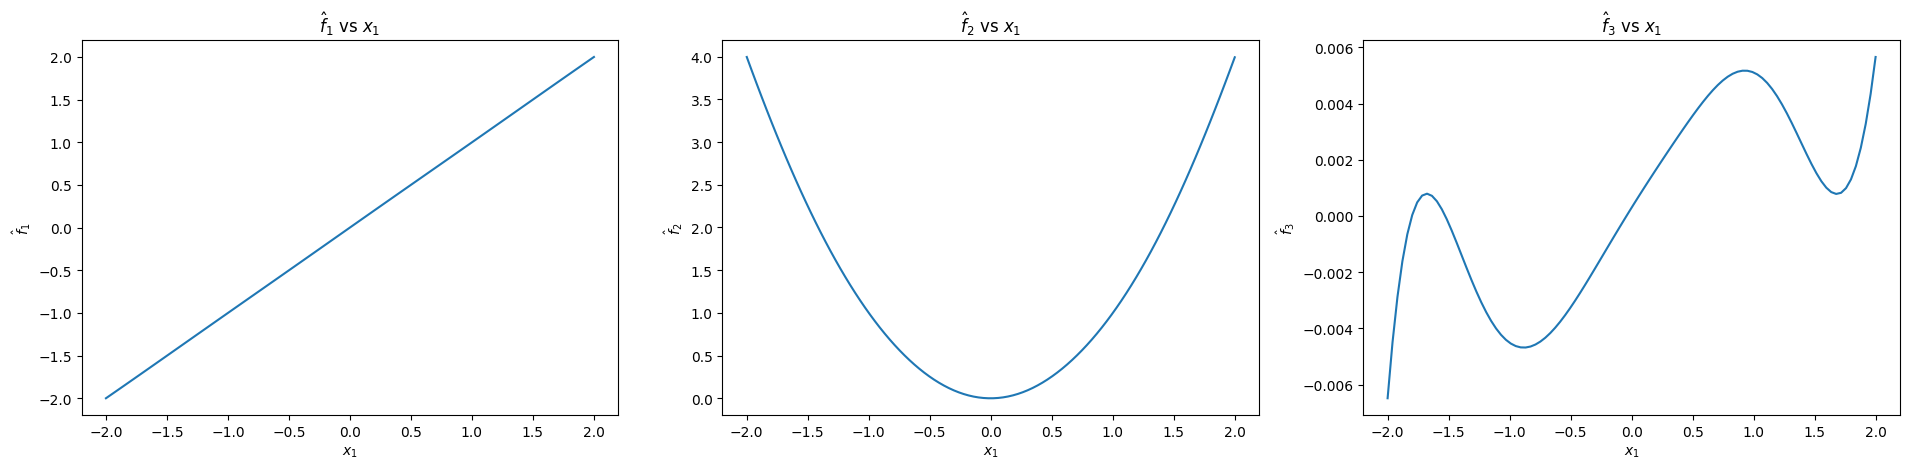

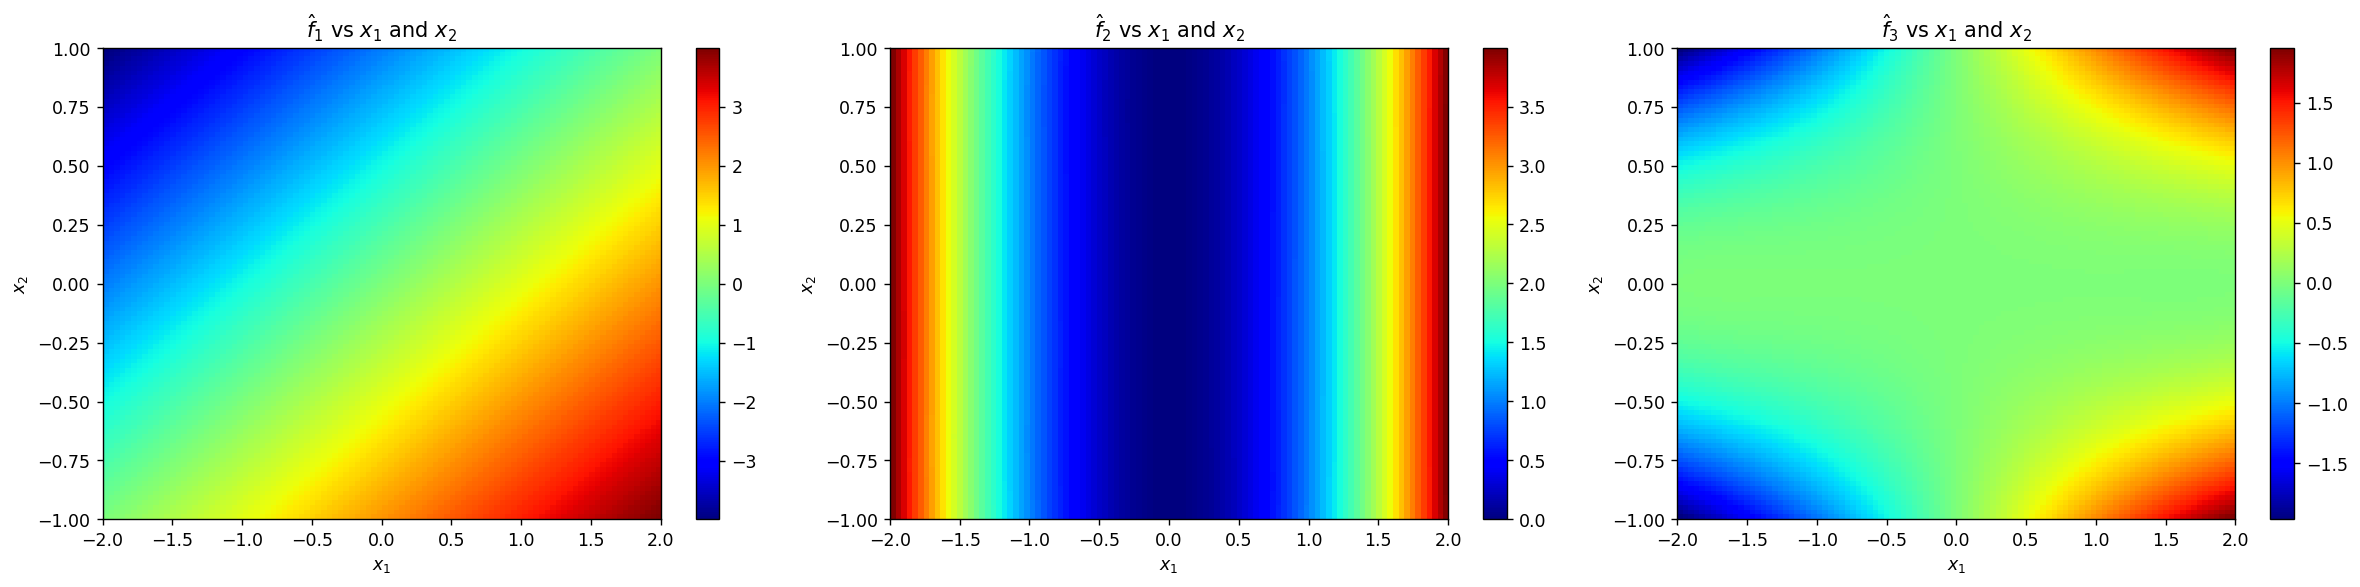

In [15]:
y_net = net(torch.from_numpy(x).float())

plt.figure(figsize=(6.4 * f.n_outputs, 4.8))

for j in range(f.n_outputs):
    plt.subplot(1, f.n_outputs, j + 1)
    plt.plot(x[:, input_to_plot - 1], y_net[:, j])

    plt.xlabel(f"$x_{input_to_plot}$")
    plt.ylabel(f"$\\hat{{f}}_{j+1}$")
    plt.title(f"$\\hat{{f}}_{j+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()

plt.show()

#

Y_net = net(torch.from_numpy(X).float())

plt.figure(dpi=125, figsize=(6.4 * f.n_outputs, 4.8))

for j in range(f.n_outputs):
    plt.subplot(1, f.n_outputs, j + 1)
    plt.imshow(
        Y_net[..., j],
        cmap="jet",
        aspect="auto",
        extent=[
            ranges[inputs_to_plot[0] - 1][0],
            ranges[inputs_to_plot[0] - 1][1],
            ranges[inputs_to_plot[1] - 1][0],
            ranges[inputs_to_plot[1] - 1][1],
        ],
    )
    plt.colorbar()

    plt.xlabel(f"$x_{inputs_to_plot[0]}$")
    plt.ylabel(f"$x_{inputs_to_plot[1]}$")
    plt.title(
        f"$\\hat{{f}}_{j+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$"
    )

plt.tight_layout()

plt.show()

And the differences with the original function

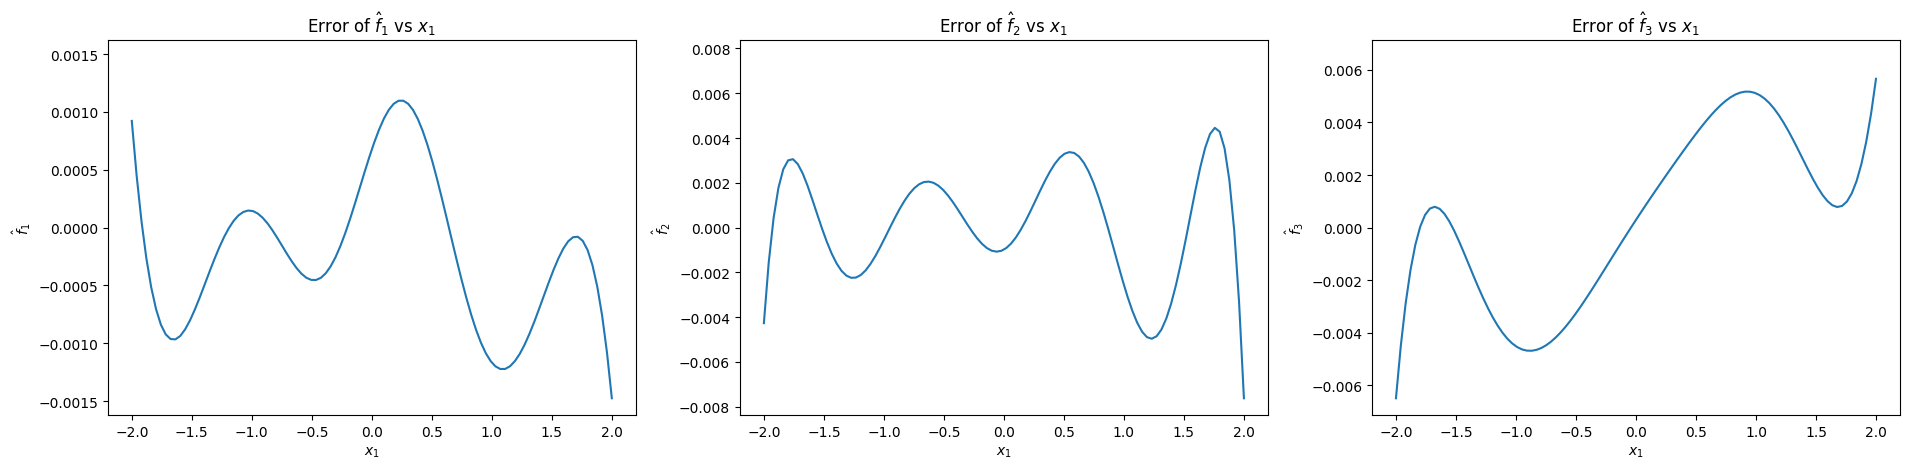

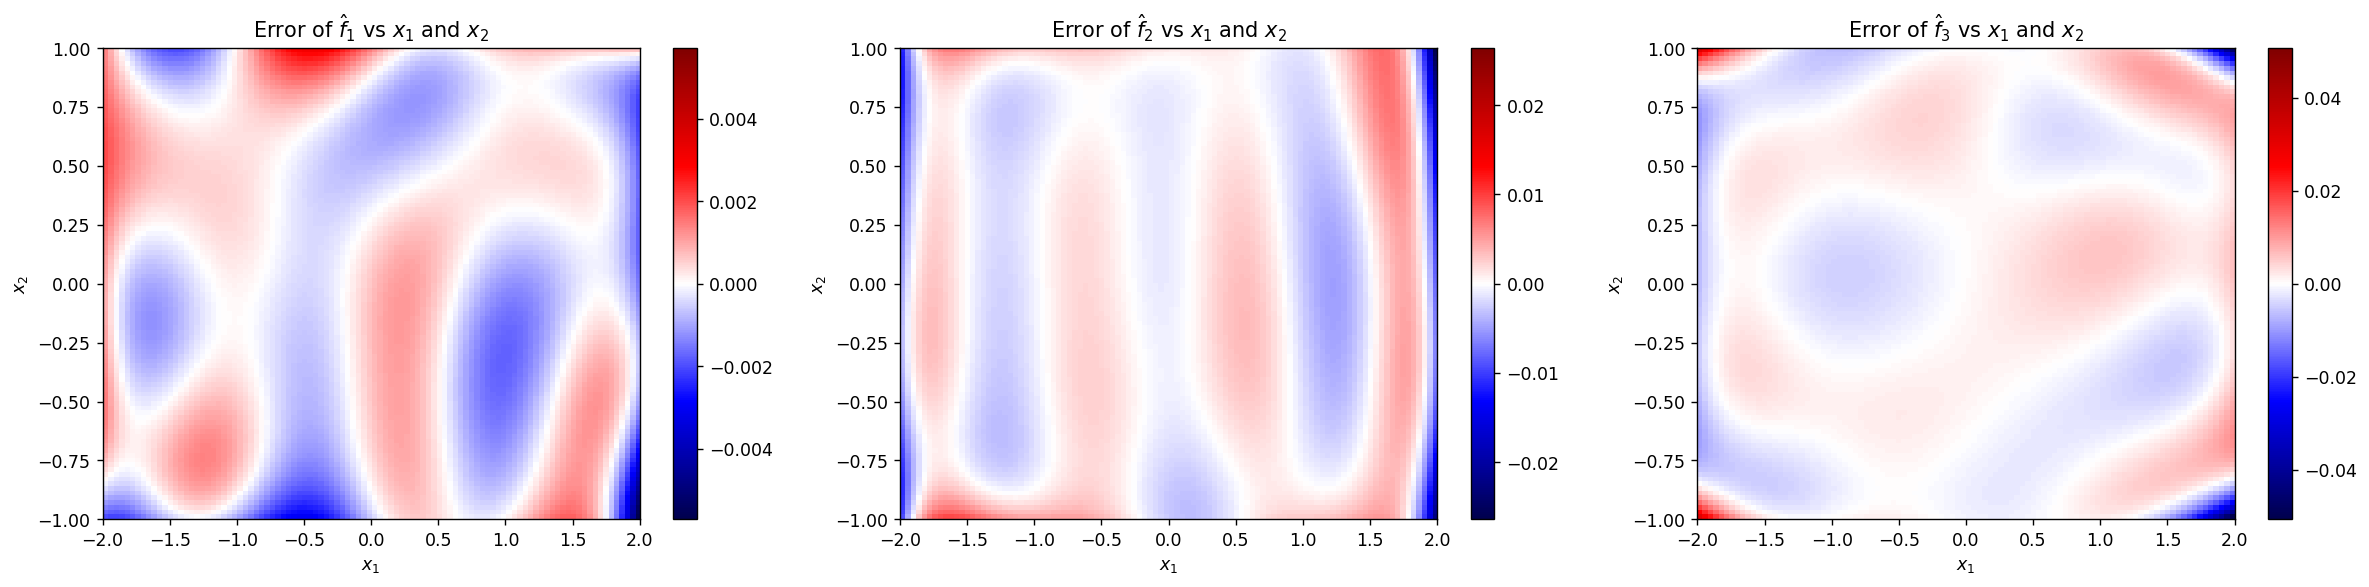

In [16]:
error_net = y_net - y

plt.figure(figsize=(6.4 * f.n_outputs, 4.8))

for j in range(f.n_outputs):
    vmax = np.abs(error_net[:, j]).max()

    plt.subplot(1, f.n_outputs, j + 1)
    plt.plot(x[:, input_to_plot - 1], error_net[:, j])
    plt.ylim([-1.1 * vmax, 1.1 * vmax])

    plt.xlabel(f"$x_{input_to_plot}$")
    plt.ylabel(f"$\\hat{{f}}_{j+1}$")
    plt.title(f"Error of $\\hat{{f}}_{j+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()

plt.show()

#

Error_net = Y_net - Y

plt.figure(dpi=125, figsize=(6.4 * f.n_outputs, 4.8))

for j in range(f.n_outputs):
    vmax = np.abs(Error_net[..., j]).max()

    plt.subplot(1, f.n_outputs, j + 1)
    plt.imshow(
        Error_net[..., j],
        cmap="seismic",
        aspect="auto",
        extent=[
            ranges[inputs_to_plot[0] - 1][0],
            ranges[inputs_to_plot[0] - 1][1],
            ranges[inputs_to_plot[1] - 1][0],
            ranges[inputs_to_plot[1] - 1][1],
        ],
        vmin=-vmax,
        vmax=vmax,
    )
    plt.colorbar()

    plt.xlabel(f"$x_{inputs_to_plot[0]}$")
    plt.ylabel(f"$x_{inputs_to_plot[1]}$")
    plt.title(
        f"Error of $\\hat{{f}}_{j+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$"
    )

plt.tight_layout()
plt.show()

## Saving and loading the trained network

In this last part, we will show how to save and load a neural network.

In [17]:
path = os.path.join(os.path.splitext(os.path.abspath(""))[0], "out-training")

net.save("network", path)

We can now load it:

In [18]:
loaded_net = FullyConnected.load("network", path)
print(loaded_net)

FullyConnected:
	layers_sizes: [2, 100, 100, 3]
	activation: GELU(approximate='none')
	batch_norm: False
	inputs_names: None
	outputs_names: None
	inputs_transformer: None
	outputs_transformer: None
	device: cpu
	last_restrictable: True



We can verify that the loaded network is doing the same operation than the one that have been trained:

In [19]:
diff_mean = np.mean(
    np.abs(
        loaded_net(torch.from_numpy(x).float()).detach().numpy()
        - net(torch.from_numpy(x).float()).detach().numpy()
    )
)
print(f"Difference of outputs between net and loaded_net: {diff_mean:.2e}")

Difference of outputs between net and loaded_net: 0.00e+00
